In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
sys.path.append('/Users/ban115/bolton/craft/code/python') # for calc11
import calc11
import numpy as np
%matplotlib inline


In [70]:
fc = 0.888 # center frequency GHz
bw = 0.256 # bandwidth GHz
Nd = 1024 # number of DM trials
Nt = 256 # time block size
Nb = 4 # bytes per complex sample. 4 = fp16 complex
Tint = 1e-3 # integration time - seconds
Nchan=256
Npol = 2 # input number of polarisations
Npix = 256
ignore_ant = ['ak30','ak31','ak32','ak33','ak34','ak35','ak36']


f1 = fc - bw/2.
f2 = fc + bw/2.
chanbw = 1e-3
lam1 = 3e8/f1/1e9
lam2 = 3e8/f2/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = 3e8/freqs/1e9
print lam1, lam2, lambdas.min(), lambdas.max(), freqs.min(), freqs.max()


0.394736842105 0.295275590551 0.29556650246305416 0.39473684210526316 0.76 1.0150000000000001


In [71]:
cfile = calc11.ResultsFile('SB6637neweop_alltell.im')

In [72]:
mjd = cfile.scans[0].first_mjd
p = cfile.scans[0].eval_src0_poly(mjd)
telnames = [t for t in cfile.telnames if t.lower() not in ignore_ant]
print 'Got', len(telnames), 'antennas'

Got 29 antennas


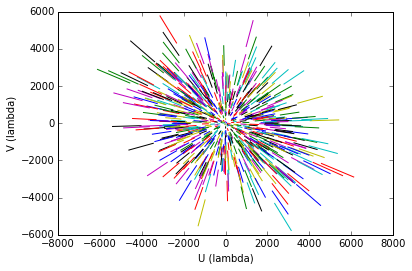

In [73]:
figure()
all_rlam = []
uvw = []
for ia1, a1 in enumerate(telnames):
    for ia2, a2 in enumerate(telnames[ia1+1:]):
        #u = [val[a1]['U (m)'] - val[a2]['U (m)'] for val in values]
        #v = [val[a1]['V (m)'] - val[a2]['V (m)'] for val in values]
        #w = [val[a1]['W (m)'] - val[a2]['W (m)'] for val in values]
        u = p[a1]['U (m)'] - p[a2]['U (m)']
        v = p[a1]['V (m)'] - p[a2]['V (m)']
        w = p[a1]['W (m)'] - p[a2]['W (m)']
        uvw.append((u,v,w))
        #print a1, a2, u, v, w
        ulam1, vlam1, wlam1 = u/lam1, v/lam1, w/lam1
        ulam2, vlam2, wlam2 = u/lam2, v/lam2, w/lam2
        r = np.sqrt(u*u + v*v)
        rlam1 = r/lam1
        rlam2 = r/lam2
        all_rlam.append((rlam1 - rlam2))
        plot([ulam1, ulam2], [vlam1, vlam2])
        plot([-ulam1, -ulam2], [-vlam1, -vlam2])

        
xlabel('U (lambda)')
ylabel('V (lambda)')
uvw = np.array(uvw)
uvwlam1 = uvw/lam1
uvwlam2 = uvw/lam2

In [74]:
assert(lam2 < lam1)

urange = uvwlam2[:, 0].max() - uvwlam2[:, 0].min()
vrange = uvwlam2[:, 1].max() - uvwlam2[:, 1].min()
lres = np.degrees(1.0/urange)*3600.
mres = np.degrees(1.0/vrange)*3600.
ucell = urange/float(Npix)*1.1
vcell = vrange/float(Npix)*1.1
lsize = np.degrees(1./ucell)
msize = np.degrees(1./vcell)
cellsize = min(ucell, vcell)

print 'UV range={:0.1f}x{:0.1f} lambda = {:0.1f}x{:0.1f} arcsec FoV: {:0.2f}x{:0.2f} deg'.format(urange, vrange, lres, mres,lsize, msize)

UV range=11526.3x10051.3 lambda = 17.9x20.5 arcsec FoV: 1.16x1.33 deg


In [75]:
# loop through baselines, working out the rounded uv cells where each one starts and stops
uvcell_start = np.round(uvwlam1/cellsize)
uvcell_end = np.round(uvwlam2/cellsize)

# radius in uv at which the track starts
rstart = np.sqrt(uvcell_start[:, 0]**2 + uvcell_start[:, 1]**2)
# radius at which it ends
rend = np.sqrt(uvcell_end[:, 0]**2 + uvcell_end[:, 1]**2)
rdist = rend - rstart 
rd30 = rdist.mean()*(30*29/2.) # guessing at the total non-zero uv plane for 30 antennas
print 'Radial distances', len(rdist), 'baselines', rdist.max(), rdist.min(), rdist.mean(), rdist.sum(), 'max/min/mean/sum'
print 'Guessing at ', rd30, 'Nonzero UVcells for 30 antennas'

Radial distances 406 baselines 39.81205574486607 0.0 13.873453934665077 5632.622297474021 max/min/mean/sum
Guessing at  6034.952461579309 Nonzero UVcells for 30 antennas


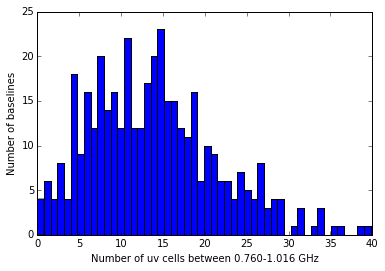

In [76]:
hist(rdist, bins=50)
xlabel('Number of uv cells between {:0.3f}-{:0.3f} GHz'.format(f1,f2))
ylabel('Number of baselines')

In [77]:
print 'Required memory', rdist.sum()*Nd*Nt*4/1e9, 'GBytes or', rdist.mean()*(30*29/2)*Nd*Nt*4/1e9, 'GBytes for 30 antennas'

Required memory 5.90623255819612 GBytes or 6.328106312352985 GBytes for 30 antennas


In [78]:
print '30 antenna UV cells', rd30, 'Per baseline mean', rdist.mean()
print 'input rate', 30*29/2*Nchan*1*Nb*Npol*8/Tint/1e9, 'Gbits/sec'

30 antenna UV cells 6034.952461579309 Per baseline mean 13.873453934665077
input rate 7.12704 Gbits/sec


In [79]:
Nd0 = 16 # Number of DM trials in first iteration
Niter = np.ceil(np.log2(Nchan))
Nbl = 30*29/2
# ah, but, you only do it for the number of baselines - because to unite 2 freqs, you don't need to read in the whole UV line
# Or do you?
print "FMDT Memory bandwidth if you only move around 1 point per iteration", Nd0*Nchan*Niter/Tint*Nb/1e9*Nbl, 'GByte/sec'
print "FMDT Memory bandwidth if you move the whole grid around per iteration", Nd0*Nchan*Niter/Tint*Nb/1e9*rd30, 'GByte/sec'

FMDT Memory bandwidth if you only move around 1 point per iteration 57.01632 GByte/sec
FMDT Memory bandwidth if you move the whole grid around per iteration 791.0132890441231 GByte/sec


 yeah, but you can just do 1 point - because when you've finished with one point, you write it to the 
 full output and never touch it again. Err, but where does it actually go in the end. Maybe you really do need to copy the whole thing. Bleah. Yeah OK - hut the size is growing (ie. it's length 1 a the beginning, and length Nmax at the end, so there's at least a factor of 2 impreovment over teh whole grid calculation).Yeah, but can you do that? how do you organise the data?
 
 
 Actually no - the trick here is to FDMT inside a cell, then just pick up data across the cells - no log2 required thankyou sir.

In [80]:
for n in (128, 192, 256):
    d = np.zeros((n,n), dtype=np.complex64)
    print 'IRFFT2', n
    %timeit np.fft.irfft2(d)
    print 'IFFT2', n
    %timeit np.fft.ifft2(d)
    print 'HFFT', n
    %timeit np.fft.hfft(d)

IRFFT2 128
100 loops, best of 3: 2.79 ms per loop
IFFT2 128
1000 loops, best of 3: 462 µs per loop
HFFT 128
100 loops, best of 3: 2.56 ms per loop
IRFFT2 192
100 loops, best of 3: 8.87 ms per loop
IFFT2 192
1000 loops, best of 3: 990 µs per loop
HFFT 192
100 loops, best of 3: 8.42 ms per loop
IRFFT2 256
100 loops, best of 3: 3.2 ms per loop
IFFT2 256
1000 loops, best of 3: 1.81 ms per loop
HFFT 256
100 loops, best of 3: 2.15 ms per loop


In [81]:
def dogrid(uvw_m, freqs, ucell, vcell, Npix, unique=False):
    g = np.zeros((Npix, Npix))
    lambdas = 3e8/freqs/1e9
    alluv = []
    for ibl in xrange(uvw_m.shape[0]):
        u,v,w = uvw_m[ibl, :]
        ulam = u/lambdas
        vlam = v/lambdas
        upix = np.round(ulam/ucell + float(Npix)/2.0).astype(int) 
        vpix = np.round(vlam/vcell + float(Npix)/2.0).astype(int)
        #print upix, vpix
        
        assert np.all(upix >= 0), "invalid upix{}".format(upix)
        assert np.all(upix < Npix)
        assert np.all(vpix >=0)
        assert np.all(vpix < Npix), 'invalid vpix ibl={}{}'.format(ibl, vpix)

        alluv.append((vpix, upix))
        
        # If upix or vpix contain multiple N identical indices, the it only increments by 1, not by 
        # N as expected. So we need to unroll the loop
        #g[vpix,upix] += 1
        uvpix = np.array([upix, vpix])
        if unique:
            uvpix = np.unique(uvpix, axis=1)
            
        for vp,up in uvpix.T:
            g[vp,up] += 1
            g[-vp,-up] += 1

        #print u,v,w,ucell[0],vcell[0],ucell[-1],vcell[0],vcell[-1]
        

    alluv = np.array(alluv)
    print alluv.shape
    return g
    

('Shape', (406, 3), 'ucell', 49.52724221349694, 'vcell', 43.18902250566826)
(array([1807.52424903, 1702.54567004, 1404.54631819]), array([6115.45704255, 5760.27951695, 4752.04837653]), 52.55470895942825)
(406, 2, 256)
('NUV=', 9350)


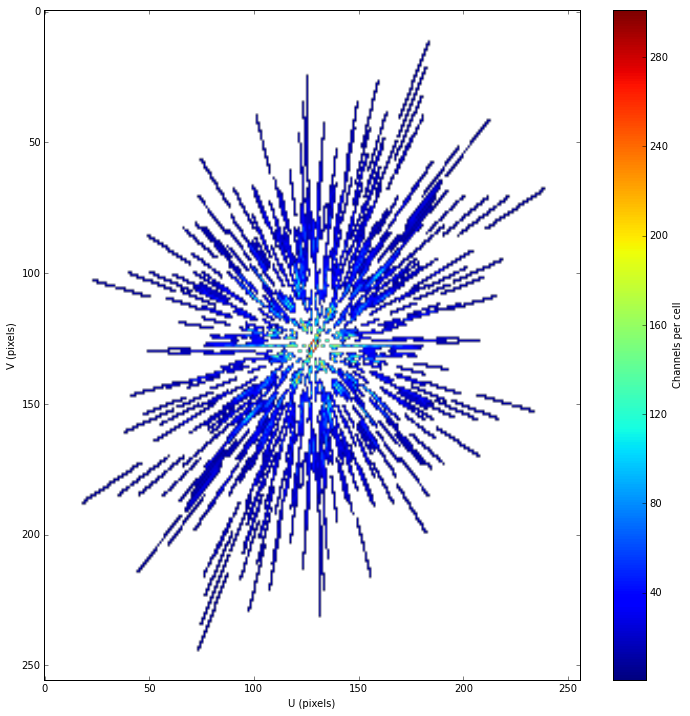

In [82]:
print('Shape', uvw.shape, 'ucell', ucell, 'vcell', vcell)
uvwamax = abs(uvw).max(axis=0)
uvwamax_lam = uvwamax/lambdas.min()
cell = uvwamax_lam[:2].max()/Npix * 2.2# max of the ucel and vcell
print(uvwamax, uvwamax_lam, cell)
thegrid = dogrid(uvw[:,:], freqs, cell, cell, Npix, unique=False)
thegridm0 = np.ma.masked_equal(thegrid, 0)
figure(figsize=[12,12])
imshow(thegridm0, aspect='auto')
colorbar(label='Channels per cell')
xlabel('U (pixels)')
ylabel('V (pixels)')
nuv = np.sum(thegrid != 0)
print('NUV=', nuv)


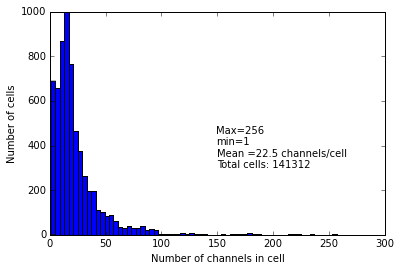

In [67]:
gf = thegridm0.flatten()
x = hist(gf, bins=np.arange(1,288,4), normed=False, cumulative=False)
text(150,300,'Max={:0.0f}\nmin={:0.0f}\nMean ={:0.1f} channels/cell\nTotal cells: {:0.0f}'.format(gf.max(), gf.min(), gf.mean(), gf.sum()))
xlabel('Number of channels in cell')
ylabel('Number of cells')

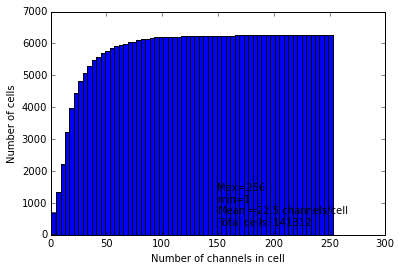

In [69]:
gf = thegridm0.flatten()
x = hist(gf, bins=np.arange(1,256,4), normed=False, cumulative=True)

text(150,300,'Max={:0.0f}\nmin={:0.0f}\nMean ={:0.1f} channels/cell\nTotal cells: {:0.0f}'.format(gf.max(), gf.min(), gf.mean(), gf.sum()))
xlabel('Number of channels in cell')
ylabel('Number of cells')

In [ ]:
plot((thegridm0 != 0).sum(axis=1))
xlabel('U (pixels)')
ylabel('Number of non-zero pixels in row')

('Shape', (406, 3), 'ucell', 45.024765648633576, 'vcell', 39.26274773242569)
(array([1807.52424903, 1702.54567004, 1404.54631819]), array([6115.45704255, 5760.27951695, 4752.04837653]), 52.55470895942825)
(406, 2, 256)


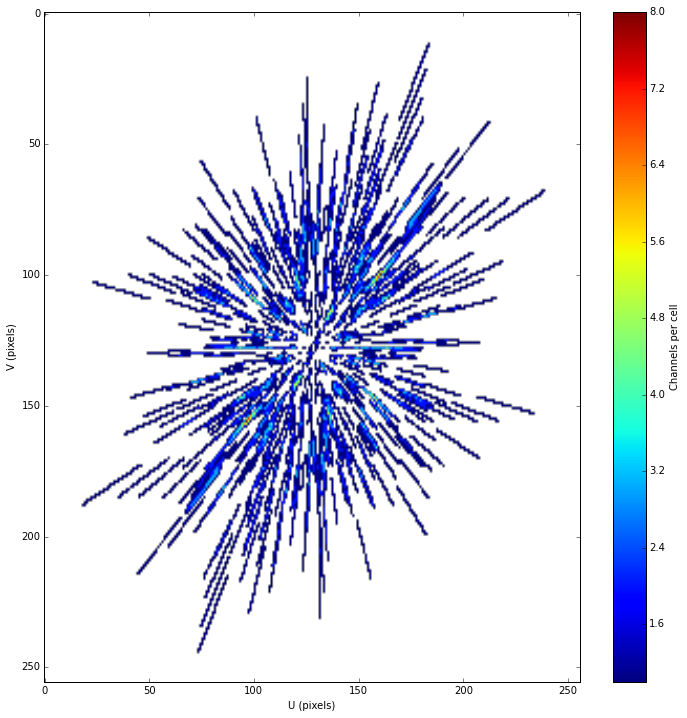

In [18]:
print('Shape', uvw.shape, 'ucell', ucell, 'vcell', vcell)
uvwamax = abs(uvw).max(axis=0)
uvwamax_lam = uvwamax/lambdas.min()
cell = uvwamax_lam[:2].max()/Npix*2*1.1 # max of the ucel and vcell
print(uvwamax, uvwamax_lam, cell)
thegrid = dogrid(uvw[:,:], freqs, cell, cell, Npix, unique=True)
thegridm0 = np.ma.masked_equal(thegrid, 0)
figure(figsize=[12,12])
imshow(thegridm0, aspect='auto')
colorbar(label='Channels per cell')
xlabel('U (pixels)')
ylabel('V (pixels)')


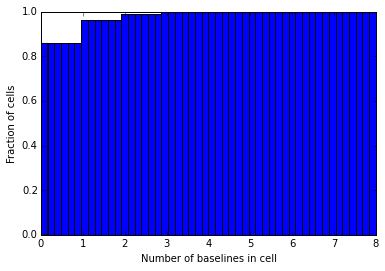

In [19]:
gf = thegridm0.flatten()
x = hist(gf, bins=50, normed=True, cumulative=True)
#text(3, 40000,'Max={:0.0f}\nmin={:0.0f}\nMean ={:0.1f} channels/cell\nTotal cells: {:0.0f}'.format(gf.max(), gf.min(), gf.mean(), gf.sum()))
xlabel('Number of baselines in cell')
ylabel('Fraction of cells')

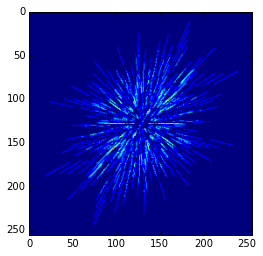

In [20]:
imshow(thegrid)

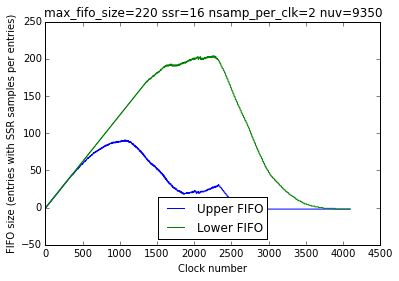

In [21]:
raster = thegrid.flatten()
nsamp_per_clk = 2
ssr = 16
max_fifo_size = 220
nuv = np.sum(raster > 0)


all_fifo_size = []

class Fifo(object):
    def __init__(self, nuv, max_fifo_size):
        self.fifo_size = 0
        self.input_stage_size = 0
        self.max_fifo_size = max_fifo_size
        self.nuv = nuv
        self.output_stage_size = 2*ssr
        self.n = 2*ssr
        
    def use_output(self):
        self.output_stage_size -= 1
        
    def update(self):
        if self.output_stage_size < ssr:
            self.fifo_size -= 1
            self.output_stage_size += ssr
            
        if self.input_stage_size == ssr and self.fifo_size < self.max_fifo_size:
            self.fifo_size += 1
            self.input_stage_size = 0
       
        if self.n < self.nuv:
            self.input_stage_size += nsamp_per_clk
            self.n += nsamp_per_clk
        
        

npix = thegrid.shape[0]
upper_nuv = 0
lower_nuv = 0
for y in xrange(npix):
    for x in xrange(npix):
        if thegrid[y][x] != 0.0:
            if x >= y:
                upper_nuv += 1
            else:
                lower_nuv += 1
            


upper_fifo = Fifo(upper_nuv, max_fifo_size)
lower_fifo = Fifo(lower_nuv, max_fifo_size)

for y in xrange(npix):
    for xx in xrange(npix/ssr):
        for i in xrange(ssr):
            x = xx*ssr + i
            if thegrid[y][x] != 0.0:
                if x >= y:
                    upper_fifo.use_output()
                else:
                    lower_fifo.use_output()
                    
        
        upper_fifo.update()
        lower_fifo.update()
        
        all_fifo_size.append((upper_fifo.fifo_size, lower_fifo.fifo_size))
    
all_fifo_size = np.array(all_fifo_size)
plot(all_fifo_size)
xlabel('Clock number')
ylabel('FIFO size (entries with SSR samples per entries)')
title('max_fifo_size=%d ssr=%d nsamp_per_clk=%d nuv=%d' % (max_fifo_size, ssr, nsamp_per_clk, nuv))
legend(('Upper FIFO','Lower FIFO'), loc='lower center')
   

In [22]:
npix

256